In [60]:
import geopandas as gpd
from shapely.geometry import Point, Polygon, LinearRing
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import utm
import rasterio
from rasterstats import zonal_stats

In [61]:
basedir = '/data/mangrove-data/Kathy/biomass_project/downsampling'
site_name = 'lap_07-18_site1'
mangrove_label = f'{basedir}/{site_name}/water-soil-mangrove/class_mangrove.gpkg'
water_label = f'{basedir}/{site_name}/water-soil-mangrove/class_water.gpkg'

In [62]:
# helper function to generate random points
def get_random_points(mangrove_poly, n):
    # get bounds for mangroves
    x_min, y_min, x_max, y_max = mangrove_poly.total_bounds

    x = np.random.uniform(x_min, x_max, n)
    y = np.random.uniform(y_min, y_max, n)

    # convert them to a points GeoSeries
    points = gpd.GeoSeries(gpd.points_from_xy(x, y))
    # only keep those points within mangrove_polys- need to keep all points within
    points = points[points.within(mangrove_poly.unary_union)]
    # add more points if not up to n
    while len(points) < n:
        # generate another random distribution
        x = np.random.uniform(x_min, x_max, n)
        y = np.random.uniform(y_min, y_max, n)
        temp_points = gpd.GeoSeries(gpd.points_from_xy(x, y))
        temp_points = temp_points[temp_points.within(mangrove_poly.unary_union)]
        points = gpd.GeoSeries(pd.unique(points.append(temp_points)))

    # if points > n, subset first n
    points = points.head(n)
    # set crs for utm zone 12 (baja california)
    points.crs = "EPSG:26912"
    return(points)

In [63]:
# read in files
mangrove_poly = gpd.read_file(mangrove_label)
water_poly = gpd.read_file(water_label)
# change crs to ubm
mangrove_poly = mangrove_poly.to_crs("+proj=utm +zone=12 +ellps=WGS84 +datum=WGS84 +units=m +no_def")
water_poly = water_poly.to_crs("+proj=utm +zone=12 +ellps=WGS84 +datum=WGS84 +units=m +no_def")
# sample size
samples = [10, 100, 1000]

n10_points = get_random_points(mangrove_poly, samples[0])
n100_points = get_random_points(mangrove_poly, samples[1])
n1000_points = get_random_points(mangrove_poly, samples[2])

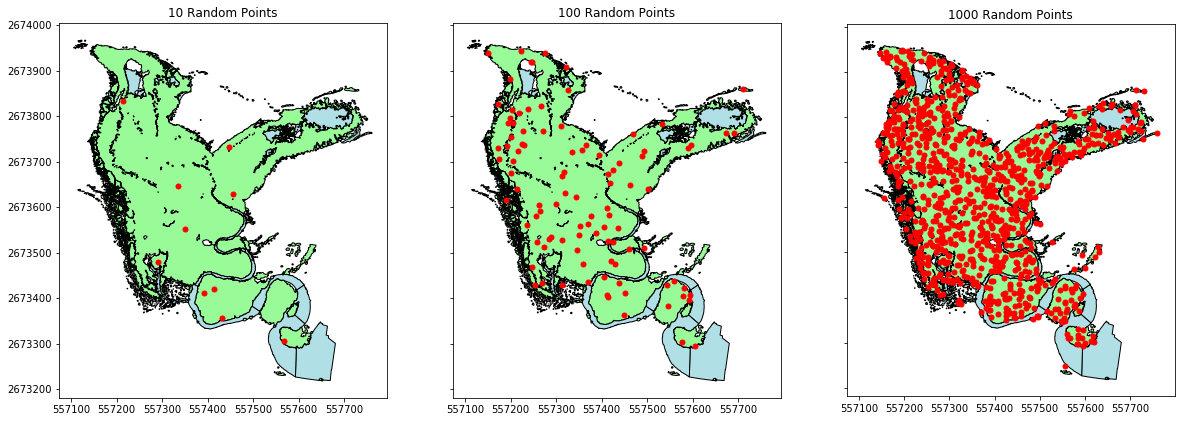

In [93]:
## show where points are initially
fig, (ax0,ax1,ax2) = plt.subplots(nrows=1, ncols=3, figsize=(20, 20), sharey=True)
ax0 = mangrove_poly.plot(ax=ax0,color='palegreen', edgecolor='black', figsize=(10, 10))
water_poly.plot(ax=ax0, color='powderblue', edgecolor='black')
n10_points.plot(ax=ax0, marker='o', color='red', markersize=25)
ax0.title.set_text('10 Random Points')

ax1 = mangrove_poly.plot(ax=ax1,color='palegreen', edgecolor='black', figsize=(10, 10))
water_poly.plot(ax=ax1, color='powderblue', edgecolor='black')
n100_points.plot(ax=ax1, marker='o', color='red', markersize=25)
ax1.title.set_text('100 Random Points')

ax2 = mangrove_poly.plot(ax=ax2,color='palegreen', edgecolor='black', figsize=(10, 10))
water_poly.plot(ax=ax2, color='powderblue', edgecolor='black')
n1000_points.plot(ax=ax2, marker='o', color='red', markersize=25)
ax2.title.set_text('1000 Random Points')

In [67]:
# find the shortest distance from point to a water polygon
def min_distance(points, water):
    return water.distance(points).min()

In [95]:
# populate points dataframe with minimum distance to water
water_geom = water_poly.geometry
df10_points = gpd.GeoDataFrame(n10_points, columns=['geometry'])
df10_points['min_dist_to_h2o'] = df10_points.geometry.apply(min_distance, args=(water_geom,))

df100_points = gpd.GeoDataFrame(n100_points, columns=['geometry'])
df100_points['min_dist_to_h2o'] = df100_points.geometry.apply(min_distance, args=(water_geom,))

df1000_points = gpd.GeoDataFrame(n1000_points, columns=['geometry'])
df1000_points['min_dist_to_h2o'] = df1000_points.geometry.apply(min_distance, args=(water_geom,))

In [100]:
# helper function to convert utm to lat/lon
def utm_to_latlon(point):
    x,y = point.coords.xy
    lat,lon = x[0],y[0]
    return utm.to_latlon(lat, lon, 12, 'N')

In [101]:
# add lat/lon coordinates back into dataframe
coords10 = df10_points.geometry.apply(utm_to_latlon)
df10_points[['lat', 'lon']] = pd.DataFrame(coords10.tolist())

coords100 = df100_points.geometry.apply(utm_to_latlon)
df100_points[['lat', 'lon']] = pd.DataFrame(coords100.tolist())

coords1000 = df1000_points.geometry.apply(utm_to_latlon)
df1000_points[['lat', 'lon']] = pd.DataFrame(coords1000.tolist())

In [106]:
# find CH values under DEM raster
lap_1_2018_dem = "/data/mangrove-data/master/2018.07-mexico-lapaz/lap-2018-07-site1/dem/lap_2018-07_site1_120m_DEM_tc.tif"
dem = rasterio.open(lap_1_2018_dem)

# need to flip order of coords for rasterio's stupid sample function
df10_points['canopy_height'] = [x[0] for x in dem.sample([(t[1], t[0]) for t in coords10])]
df100_points['canopy_height'] = [x[0] for x in dem.sample([(t[1], t[0]) for t in coords100])]
df1000_points['canopy_height'] = [x[0] for x in dem.sample([(t[1], t[0]) for t in coords1000])]

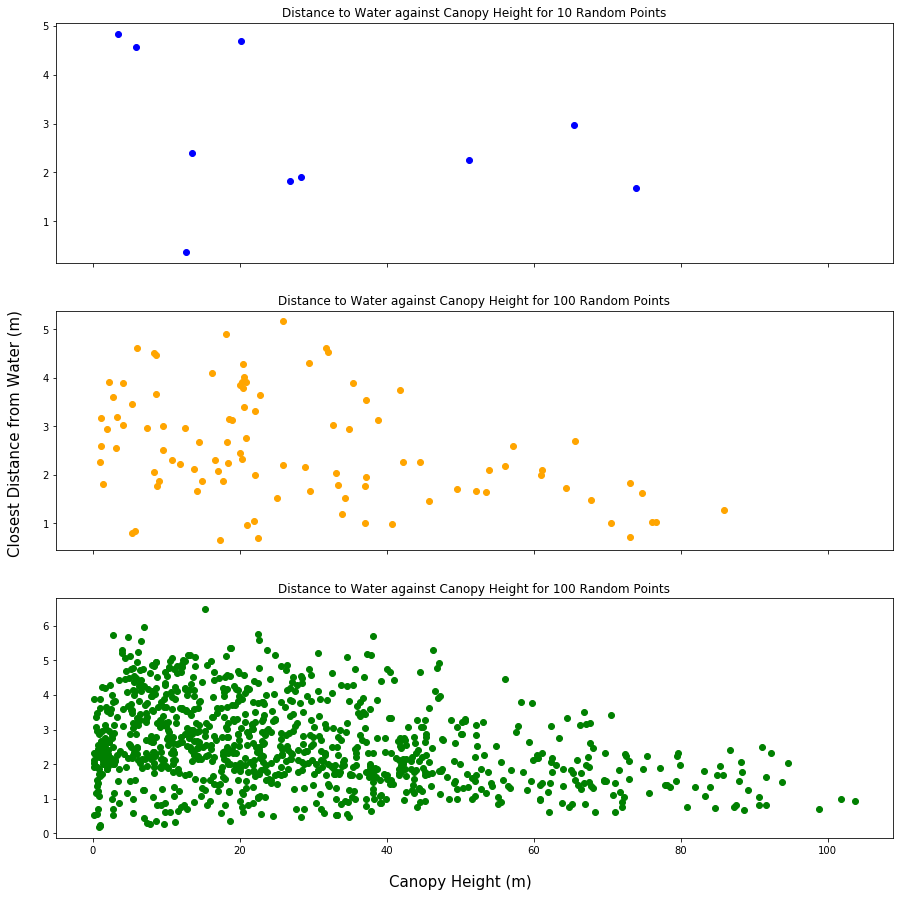

In [128]:
# plot 3 figs against each other for each point
fig, ax = plt.subplots(3, figsize=(15,15), sharex=True)
#fig.suptitle('Canopy Height Distributions', fontsize=20)
fig.text(0.08, 0.5, 'Closest Distance from Water (m)', va='center', rotation='vertical', fontsize=15)
fig.text(0.5, 0.08, 'Canopy Height (m)', ha='center', fontsize=15)

ax[0].plot(df10_points.min_dist_to_h2o, df10_points.canopy_height, marker='o', ls='', color='blue')
ax[0].title.set_text('Distance to Water against Canopy Height for 10 Random Points')

ax[1].plot(df100_points.min_dist_to_h2o, df100_points.canopy_height, marker='o', ls='', color='orange')
ax[1].title.set_text('Distance to Water against Canopy Height for 100 Random Points')

ax[2].plot(df1000_points.min_dist_to_h2o, df1000_points.canopy_height, marker='o', ls='', color='green')
ax[2].title.set_text('Distance to Water against Canopy Height for 100 Random Points')

In [131]:
# save as shapefiles
df10_points.to_file(f'{basedir}/{site_name}/water-soil-mangrove/random_points/10_points.gpkg', driver="GPKG")
df100_points.to_file(f'{basedir}/{site_name}/water-soil-mangrove/random_points/100_points.gpkg', driver="GPKG")
df1000_points.to_file(f'{basedir}/{site_name}/water-soil-mangrove/random_points/1000_points.gpkg', driver="GPKG")

In [ ]:
# save as csv files
df10_points.to_csv( f'{basedir}/{site_name}/water-soil-mangrove/random_points/10points.csv')
df100_points.to_csv( f'{basedir}/{site_name}/water-soil-mangrove/random_points/100points.csv')
df1000_points.to_csv( f'{basedir}/{site_name}/water-soil-mangrove/random_points/1000points.csv')